### v7:
    
    * Run equation parameter investigation on laptop
        * R(1-e**-M*time/tot_time), where -M could be multiples of R and C
        * initial test with varying exponential values didn't produce much change.  Save
        * lots more trials on 10/26 to try and optimize the spring functions with no luck.
        * added lightgbm model, which gives lower scores than catboost, but submissions are whacked.
        * saving this version in a buggy state, but refactor on next iteration.
        
        * maybe delta from mean
        * derivative squared?
        * Need to ensure starting values are right...shift breath_id also...start with that

### v6:
    * add u_in exponential R(1-e**-1uin/max_uin.)
        * maybe use C as multiplier instead of R and experiment with e ratios
        * didn't get great improvement. Maybe relook at physics.
    * next, add log of u_in feature? Had issues with zeros.  

### v5:

   * Add RC feature (with spring above at .5): 1.0432, .780
   * Add R/C feature (with eqn above at .5): 1.027, .7752
   * Add C/R feature also (with eqn above at .5):  1.0276, .7743
   * added breath_id back: 1.0316, .77345
   * with second deriv = 1.013, .741  some improvement!  But why doesn't the corr reflect this?
   * catboost 10000 iterations: .677 !!! It is starting to increase better at higher iterations
   * 20000 iterations: .637 approaching the RF score (.61)
   * 30000 iterations! depth=6, .5887!!  But leaderboard was .70!  
       * **I guess that means overfitting!
   * with 3rd deriv and u_in_squared added: 1.0117, .7363, try rf: .50277 vs. .5846 lb...best so far
     * baselining for v5

### Previous Versions

Adding max u_in feature helped score from  ~.75 to ~.65.

Pipeline is:
* reduce memory
* split into two sets
* add features: max_time, max_u_in, dt, u_in_slope, u_in_area

Fork v1 adds u_in_ratio feature
* catboost drops a little 1.09 to ~1.065 ,didnt run rf.

Add 1/area feature since R decreases with increasing lung volume
   * helps a little, not much
   * with 1/R*area: 1.0727, .808181 
 
v4?
Add R(1-np.exp(-1*t/t_max)
   * spring R(1-np.exp(-1*time/time_max)): 1.0661, .7899
   * spring R(1-np.exp(-2*time/time_max)): 1.0612, .7857
   * spring R(1-np.exp(-3*time/time_max)): 1.0551, .7868
   * spring R(1-np.exp(-5*time/time_max)): 1.0575, .7847
   * spring R(1-np.exp(-R*time/time_max)): 1.0529, .7877
   * spring R(1-np.exp(-.5*R*time/time_max)): 1.0541, .7842
   * spring R(1-np.exp(-.2*R*time/time_max)): 1.0549, .7854


# Libraries

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import platform
pd.options.mode.chained_assignment = None

# Functions

# Load Files

In [450]:
%%time
# Load files
if platform.system() == 'Windows' and platform.release() == '7':
    drive = 'F'
elif platform.system() == 'Windows' and platform.release() == '10':
    drive = 'C'
    
train = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')
    
#train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
#test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

y = train['pressure']


Wall time: 4.98 s


# Memory Reduction

In [451]:
# down convert columns to save memory...
def reduce_memory(df):
    
    print(f'Initial memory usage: {df.memory_usage().sum()/1024**2:0.1f}GB')
    df['id'] = df['id'].astype(np.int32)
    df['breath_id'] = df['breath_id'].astype(np.int32)
    df['R'] = df['R'].astype(np.int8)  #or OHC?
    df['C'] = df['C'].astype(np.int8)
    df['u_out'] = df['u_out'].astype(np.int8)
    df['u_in'] = df['u_in'].astype(np.float32)
    df['time_step'] = df['time_step'].astype(np.float32)
    print(f'New memory usage: {df.memory_usage().sum()/1024**2:0.1f}GB')
    
    # somewhere else I printed out a reduction as well.
    
#     for col in test.columns:
#         print(test[col].dtype)

In [452]:
print('Train:')
reduce_memory(train)
print('Test:')
reduce_memory(test)


Train:
Initial memory usage: 368.4GB
New memory usage: 155.4GB
Test:
Initial memory usage: 214.9GB
New memory usage: 72.9GB


# Split data into inhalitory and exhalitory phase (only scored on inhale)

In [453]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

### Get indicies of valid breaths, and indicies of transition

In [454]:
#check for infinite or nan values

#train_in.inv_area.isinf().sum()
#np.isinf(train_in).values.sum()

#  Add Features

    1. Apply lag shift (tested shift =1 ) 
        Shift = 2 performs better (2.37 vs. 2.0x)
    2. Add differentials for dt and du_in
    3. Add integral column for d_uin



### Apply lag shift, Add Differential, Integral, and other Features

In [455]:
def apply_features(df,ushift):
    
    # apply lag shift
    shift = ushift
    u_in_lag = df.u_in.shift(shift,fill_value=0)
    df.loc[:,'u_in_lag'] = u_in_lag.copy()

    # max/min features
    df["max_u_in"] = df.groupby("breath_id")["u_in"].transform("max")
    df["max_time"] = df.groupby("breath_id")["time_step"].transform("max")
    
    # ratios
    df["u_in_ratio"] = df.u_in/df.max_u_in
    df["u_in_ratio"] = df.u_in_ratio.fillna(0)
    df['RC'] = df.R * df.C
    df['RoverC'] = df.R/df.C
    df['CoverR'] = df.C/df.R
    
    # dt
    df['dt'] = df['time_step'].diff()
    df['dt'].fillna(0, inplace=True)  # no na values so not needed
    df['dt'].mask(df['dt'] < 0,0,inplace=True) #df.groupby('breath_id')['dt'].mean(), inplace=True)  #makes
    
    # derivatives   
    df['du_in'] = df['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
    df['du_in'].mask(df['dt'] == 0, 0, inplace=True)
    #df['dt'].fillna(0, inplace=True)
    df['du2_in'] = df['du_in'].diff()
    df['du2_in'].mask(df['dt'] == 0, 0, inplace=True)
    df['du3_in'] = df['du2_in'].diff()
    df['du3_in'].mask(df['dt'] == 0, 0, inplace=True)

    # integration
    df['d_area'] = np.sqrt(df['dt'] * df['u_in_lag'])
    df['u_in_area'] = df.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
    df['inv_area'] = train_in.C/df['u_in_area']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['inv_area'].fillna(0, inplace=True)
    df['u_in_sq'] = df.u_in_lag * df.u_in_lag
    df['u_in_cube'] = df.u_in_lag**3/1000
    df['u_in_ts'] = df.u_in_lag*df.time_step

    # formulas
    df['R_spring'] = df.R*(1-np.exp((-.32*df.R*df.time_step)/(df.max_time)))
    df['U_spring'] = df.C*(1-np.exp((-.08*df.C*df.u_in_lag)/(df.max_u_in)))
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['R_spring'].fillna(0, inplace=True)
    df['U_spring'].fillna(0, inplace=True)

    # Drop unused axes
    #df.drop(['d_area'],axis=1,inplace=True)
    df.drop(['u_in'],axis=1,inplace=True)


In [456]:
apply_features(train_in,1)
apply_features(test_in,1)

In [457]:
np.isinf(train_in).values.sum()
train_in.isna().sum()

id            0
breath_id     0
R             0
C             0
time_step     0
u_out         0
pressure      0
u_in_lag      0
max_u_in      0
max_time      0
u_in_ratio    0
RC            0
RoverC        0
CoverR        0
dt            0
du_in         0
du2_in        0
du3_in        0
d_area        0
u_in_area     0
inv_area      0
u_in_sq       0
u_in_cube     0
u_in_ts       0
R_spring      0
U_spring      0
dtype: int64

In [477]:
# this doesn't seem to be useful in selecting features.
#plt.figure(figsize=(17,15))
#sns.heatmap(train_in.corr(),annot=True)
#plt.savefig('heatmap',dpi=300)
np.abs(train_in.corrwith(y_in)).sort_values(ascending=False)

u_in_area     0.636851
max_u_in      0.490235
time_step     0.415618
u_in_ts       0.390139
d_area        0.262755
u_in_lag      0.234325
u_in_ratio    0.210349
dt            0.209990
du_in         0.178145
R_spring      0.171671
u_in_sq       0.169986
du2_in        0.139938
CoverR        0.129317
u_in_cube     0.127530
inv_area      0.121243
C             0.098407
du3_in        0.078225
U_spring      0.056106
R             0.053629
max_time      0.047496
RoverC        0.043455
RC            0.039064
breath_id     0.004680
dtype: float64

Visualize features

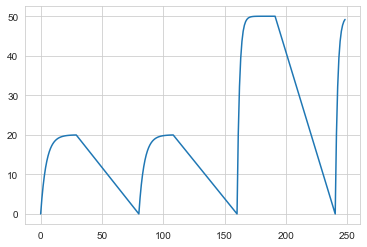

In [478]:

plt.plot(train_in.R_spring[0:100])


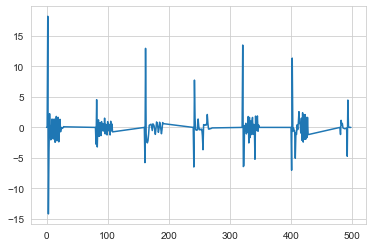

In [460]:
plt.plot(train_in.du2_in[0:200])

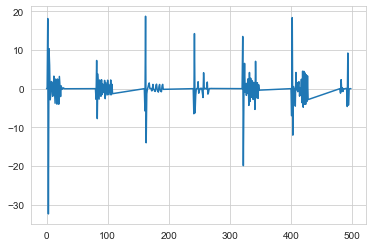

In [461]:
plt.plot(train_in.du3_in[0:200])

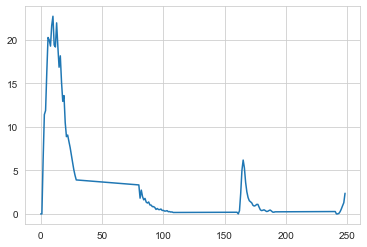

In [462]:
plt.plot(train_in.u_in_cube[0:100])

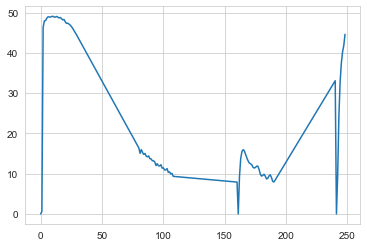

In [463]:
plt.plot(train_in.U_spring[0:100])

In [464]:
#train_in.head(33)

# Model

In [465]:
from sklearn.metrics import mean_absolute_error  #confusion_matrix, classification_report

## Need to ditch split and go to cross validation

In [466]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

train_in.drop(columns = ['id','u_out','pressure'], inplace = True)
X_test_in = test_in.drop(columns = ['id','u_out'], inplace = False)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)


In [467]:
test_in

,id,breath_id,R,C,time_step,u_out,u_in_lag,max_u_in,max_time,u_in_ratio,...,du2_in,du3_in,d_area,u_in_area,inv_area,u_in_sq,u_in_cube,u_in_ts,R_spring,U_spring
0,1,0,5,20,0.000000,0,0.000000,37.542217,0.957189,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0,5,20,0.031904,0,0.000000,37.542217,0.957189,0.200176,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.259660,0.000000
2,3,0,5,20,0.063827,0,7.515046,37.542217,0.957189,0.390272,...,7.515046,7.515046,0.489803,0.489803,102.081898,56.475910,0.424419,0.479665,0.505984,5.481105
3,4,0,5,20,0.095751,0,14.651675,37.542217,0.957189,0.565513,...,-0.378416,-7.893462,0.683913,1.173716,42.599758,214.671585,3.145298,1.402913,0.739510,9.288723
4,5,0,5,20,0.127644,0,21.230610,37.542217,0.957189,0.701103,...,-0.557695,-0.179279,0.822860,1.996575,25.042883,450.738800,9.569460,2.709951,0.960690,11.907712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023945,4023946,125748,20,10,0.842145,0,0.000000,35.151390,0.976815,0.000000,...,0.000000,0.000000,0.000000,3.688204,2.711347,0.000000,0.000000,0.000000,19.919695,0.000000
4023946,4023947,125748,20,10,0.875648,0,0.000000,35.151390,0.976815,0.000000,...,0.000000,0.000000,0.000000,3.688204,2.711347,0.000000,0.000000,0.000000,19.935522,0.000000
4023947,4023948,125748,20,10,0.909185,0,0.000000,35.151390,0.976815,0.003453,...,0.000000,0.000000,0.000000,3.688204,2.711347,0.000000,0.000000,0.000000,19.948242,0.000000
4023948,4023949,125748,20,10,0.943148,0,0.121375,35.151390,0.976815,0.000000,...,0.121375,0.121375,0.064204,3.752408,2.664956,0.014732,0.000002,0.114474,19.958567,0.027585


In [433]:
# cross validation
# from catboost import CatBoostRegressor
# from sklearn.model_selection import cross_val_score

# model_cat = CatBoostRegressor(loss_function="MAE",
#                                eval_metric="MAE",
#                                task_type="GPU",
#                                learning_rate=.6,
#                                iterations=i,
#                                l2_leaf_reg=50,
#                                random_seed=12,
#                                #od_type="Iter",
#                                depth=5,
#                                #early_stopping_rounds=6500,
#                                #border_count=64,
#                                verbose=False
#                               )
# model_cat.fit(train_in, y_in)
# print('Train Accuracy',cross_val_score(model_cat, X_train, y_train, 
#     cv=3, scoring='accuracy'))
# print('Test Accuracy',cross_val_score(CatBoost_clf, X_test, y_test, cv=3, 
#     scoring='accuracy'))

In [468]:
#test_in["u_in_ratio"] = test_in.u_in_ratio.fillna(0)
test_in.isna().sum()

id            0
breath_id     0
R             0
C             0
time_step     0
u_out         0
u_in_lag      0
max_u_in      0
max_time      0
u_in_ratio    0
RC            0
RoverC        0
CoverR        0
dt            0
du_in         0
du2_in        0
du3_in        0
d_area        0
u_in_area     0
inv_area      0
u_in_sq       0
u_in_cube     0
u_in_ts       0
R_spring      0
U_spring      0
dtype: int64

In [469]:
%%time
from catboost import CatBoostRegressor
# loop for manual type cv

# base = 4
# r = [base**i for i in range(10)]
# nr = np.array(r)
# nr2 = .1*nr

for i in [400,4000]:
#     train_in['R_spring'] = train_in.R*(1-np.exp((-i*train_in.time_step)/train_in.R*train_in.C*train_in.max_time))
# #     train_in['U_spring'] = train_in.C*(1-np.exp((-i*train_in.C*train_in.u_in_lag)/train_in.max_u_in))
#     train_in['R_spring'].fillna(0, inplace=True)
# #     train_in['U_spring'].fillna(0, inplace=True)
#     X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
#                                                       random_state=12)
    model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               task_type="GPU",
                               learning_rate=.6,
                               iterations=i,
                               l2_leaf_reg=50,
                               random_seed=12,
                               #od_type="Iter",
                               depth=5,
                               #early_stopping_rounds=6500,
                               #border_count=64,
                               verbose=False
                              )
    model_cat.fit(X_train,y_train)
    pred_cat = model_cat.predict(X_valid)
    score_cat = mean_absolute_error(y_valid,pred_cat)
    #print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
    print(f'CatBoost MAE Score, i = {i}: {score_cat}')


# #for i in np.arange(.01,1, .05):
    
#    train_in['R_spring'] = train_in.R*(1-np.exp((-i*train_in.R*train_in.time_step)/train_in.max_u_in))
#    train_in['U_spring'] = train_in.C*(1-np.exp((-i*train_in.C*train_in.u_in_lag)/train_in.max_u_in))
# CatBoost MAE Score: 0.823452805207751
# CatBoost MAE Score: 0.8244906642216089
# CatBoost MAE Score: 0.8224852645009877
# CatBoost MAE Score: 0.820939165244895
# CatBoost MAE Score: 0.828103261174823
# CatBoost MAE Score: 0.8276944350818265
# CatBoost MAE Score: 0.82250333177377
# CatBoost MAE Score: 0.8260069198370071
# CatBoost MAE Score: 0.8273281142558938
# CatBoost MAE Score: 0.827665713657084
# CatBoost MAE Score: 0.8239894011283437
# CatBoost MAE Score: 0.8199656501911918
# CatBoost MAE Score: 0.8221365504760196
# CatBoost MAE Score: 0.8238334034865284
# CatBoost MAE Score: 0.8233038737722059
# CatBoost MAE Score: 0.8236083521058299
# CatBoost MAE Score: 0.8252890846398361
# CatBoost MAE Score: 0.8198454755408158
# CatBoost MAE Score: 0.8233643939860046
# CatBoost MAE Score: 0.8231664344552851
# crap, Ichanged them both at once!
    # but not much change .819 to .828
    
# not changing c 
# train_in['R_spring'] = train_in.R*(1-np.exp((-i*train_in.R*train_in.time_step)/train_in.max_time))
# CatBoost MAE Score: 0.7350208651837546
# CatBoost MAE Score: 0.7355052480928236
# CatBoost MAE Score: 0.732265521959259
# CatBoost MAE Score: 0.7338396634157698
# CatBoost MAE Score: 0.7327744095923245
# CatBoost MAE Score: 0.7335933546759111
# CatBoost MAE Score: 0.7336425373812954
# CatBoost MAE Score: 0.7359197908246126
# CatBoost MAE Score: 0.7350552247367084
# CatBoost MAE Score: 0.7334611369724444
# CatBoost MAE Score: 0.735324320273796
# CatBoost MAE Score: 0.7351512671628837
# CatBoost MAE Score: 0.7327071647204526
# CatBoost MAE Score: 0.732849066857986
# CatBoost MAE Score: 0.7355317480948735
# CatBoost MAE Score: 0.7335369128136215
# CatBoost MAE Score: 0.735746990895848
# CatBoost MAE Score: 0.7367099223899597
# CatBoost MAE Score: 0.7339819253626697
# CatBoost MAE Score: 0.7339404206241138
# CatBoost MAE Score: 0.7334299584188981
# CatBoost MAE Score: 0.737430427693681
# CatBoost MAE Score: 0.7337816936061867
# CatBoost MAE Score: 0.7342790819764392
# CatBoost MAE Score: 0.7350582641623833
# CatBoost MAE Score: 0.7343963717411031
# CatBoost MAE Score: 0.735863964795775
# CatBoost MAE Score: 0.7363404181751033
# CatBoost MAE Score: 0.7358727028080406
# CatBoost MAE Score: 0.7346160968338963
# CatBoost MAE Score: 0.7399225397819768
# CatBoost MAE Score: 0.7361224042687732
# CatBoost MAE Score: 0.739479387692312
# CatBoost MAE Score: 0.7364025524278748
# CatBoost MAE Score: 0.7351968155208863
# CatBoost MAE Score: 0.7368743107312791
# CatBoost MAE Score: 0.7389757862790323
# CatBoost MAE Score: 0.7371696156728724
# CatBoost MAE Score: 0.7425079310892314
# CatBoost MAE Score: 0.7374847122374355
# CatBoost MAE Score: 0.7370633866010947
# CatBoost MAE Score: 0.7380561601209822
# CatBoost MAE Score: 0.7386896136808022
# CatBoost MAE Score: 0.7385738357696842
# CatBoost MAE Score: 0.7366510740522094
# CatBoost MAE Score: 0.7404307331045236
# CatBoost MAE Score: 0.7364488022534367
# CatBoost MAE Score: 0.7395123994656201
# CatBoost MAE Score: 0.7383554595666839
# CatBoost MAE Score: 0.7381259920938452
# CatBoost MAE Score: 0.7401864646699904
# CatBoost MAE Score: 0.7388750554920033
# CatBoost MAE Score: 0.7381406508452936
# CatBoost MAE Score: 0.7421497054255528
# CatBoost MAE Score: 0.7389084575086043
# CatBoost MAE Score: 0.7382879724552309
# CatBoost MAE Score: 0.7424226894706689
# CatBoost MAE Score: 0.7412144296065032
# CatBoost MAE Score: 0.739926003311699
# CatBoost MAE Score: 0.7391022229705818
# CatBoost MAE Score: 0.7399686413000883
# CatBoost MAE Score: 0.7413239764057811
# CatBoost MAE Score: 0.7395234092037942
# CatBoost MAE Score: 0.7390578900111344
# CatBoost MAE Score: 0.742512899105209
# CatBoost MAE Score: 0.7409862824116302
# CatBoost MAE Score: 0.7412102480875263
# CatBoost MAE Score: 0.7403546436856938
# CatBoost MAE Score: 0.7413884960903223
# CatBoost MAE Score: 0.7425226783952827
# CatBoost MAE Score: 0.742593130764234
# CatBoost MAE Score: 0.7396503105195685
# CatBoost MAE Score: 0.7411172638203222
# CatBoost MAE Score: 0.7408249980844427
# CatBoost MAE Score: 0.7406837601654979
# CatBoost MAE Score: 0.7423385263767616
# CatBoost MAE Score: 0.740080853079366
# CatBoost MAE Score: 0.7409942023944912
# CatBoost MAE Score: 0.7416410228941525
# CatBoost MAE Score: 0.7398627416430427
# CatBoost MAE Score: 0.7402016741607534
# CatBoost MAE Score: 0.7393762609477691
# CatBoost MAE Score: 0.7426086235275674
# CatBoost MAE Score: 0.7404732365394009
# CatBoost MAE Score: 0.7433687178391867
# CatBoost MAE Score: 0.7408869720442964
# CatBoost MAE Score: 0.7410192144758713
# CatBoost MAE Score: 0.7386944369821709
# CatBoost MAE Score: 0.7414855814006507
# CatBoost MAE Score: 0.7418033493676138
# CatBoost MAE Score: 0.7413605909360521
# CatBoost MAE Score: 0.7415283684966373
# CatBoost MAE Score: 0.7409546492801949
# CatBoost MAE Score: 0.7415543402195562
# CatBoost MAE Score: 0.7410430790949171
# CatBoost MAE Score: 0.7421747632032056
# CatBoost MAE Score: 0.7417387440929067
# CatBoost MAE Score: 0.7435730800002246
# CatBoost MAE Score: 0.7464251240492891
# CatBoost MAE Score: 0.7449118402069873
    
#train_in['R_spring'] = train_in.R*(1-np.exp((-i*train_in.R*train_in.time_step)/train_in.max_time)) 
# best = .729 at i = 18, but very little change from .1 to 50,
# CatBoost MAE Score, i = 10: 0.7422249364321033
# CatBoost MAE Score, i = 12: 0.7342141449688067
# CatBoost MAE Score, i = 14: 0.7299313078630723
# CatBoost MAE Score, i = 16: 0.7329270666127773
# CatBoost MAE Score, i = 18: 0.7299306494447323

# CatBoost MAE Score, i = 20: 0.7413108833948898
# CatBoost MAE Score, i = 22: 0.7340263918577316
# CatBoost MAE Score, i = 24: 0.7363495249182427
# Wall time: 10min 57s

# damn, this was with both variables going...still, need to get past this test
# CatBoost MAE Score, i = 0.01: 0.7350208651837546
# CatBoost MAE Score, i = 0.02: 0.7357436505234892
# CatBoost MAE Score, i = 0.04: 0.7346458010844592
# CatBoost MAE Score, i = 0.08: 0.7351860831478982
# CatBoost MAE Score, i = 0.16: 0.7378867468875564
# CatBoost MAE Score, i = 0.32: 0.7322602413109813
# CatBoost MAE Score, i = 0.64: 0.7335994787835347
# CatBoost MAE Score, i = 1.28: 0.7381329276138607
# CatBoost MAE Score, i = 2.56: 0.7388750554920033
# CatBoost MAE Score, i = 5.12: 0.7416706212630143
# CatBoost MAE Score, i = 10.24: 0.7482125238719025
# CatBoost MAE Score, i = 20.48: 0.7449343214020481
# CatBoost MAE Score, i = 40.96: 0.7453967715057037
# CatBoost MAE Score, i = 81.92: 0.7469701040437757
# CatBoost MAE Score, i = 163.84: 0.7418321083287349

# not quite making sense, but lets use .32 for R
# CatBoost MAE Score, i = 0.01: 0.7350208651837546
# CatBoost MAE Score, i = 0.02: 0.7357436505234892
# CatBoost MAE Score, i = 0.04: 0.7346457955771364
# CatBoost MAE Score, i = 0.08: 0.7351860831478982
# CatBoost MAE Score, i = 0.16: 0.733839666422943
# CatBoost MAE Score, i = 0.32: 0.7322602413109813
# CatBoost MAE Score, i = 0.64: 0.7335996909934217
# CatBoost MAE Score, i = 1.28: 0.7381330271440496
# CatBoost MAE Score, i = 2.56: 0.7388750554920033
# CatBoost MAE Score, i = 5.12: 0.7416741841457002
# CatBoost MAE Score, i = 10.24: 0.7484269876971221
# CatBoost MAE Score, i = 20.48: 0.7449343099328293
# CatBoost MAE Score, i = 40.96: 0.7453967729193748
# CatBoost MAE Score, i = 81.92: 0.7469701040437757

#does the mult * R in the exponent help?  Try with just -i.
# CatBoost MAE Score, i = 0.01: 0.7392512302165254
# CatBoost MAE Score, i = 0.02: 0.7386764822540575
# CatBoost MAE Score, i = 0.04: 0.7397064404125783
# CatBoost MAE Score, i = 0.08: 0.7384025480849986
# CatBoost MAE Score, i = 0.16: 0.7378046780067382
# CatBoost MAE Score, i = 0.32: 0.7387695316558168
# CatBoost MAE Score, i = 0.64: 0.737697810675528
# CatBoost MAE Score, i = 1.28: 0.7377218627361191
# CatBoost MAE Score, i = 2.56: 0.7369082284768212
# CatBoost MAE Score, i = 5.12: 0.7359022834367378
# CatBoost MAE Score, i = 10.24: 0.7344094471967347
# CatBoost MAE Score, i = 20.48: 0.7326405538007266
# CatBoost MAE Score, i = 40.96: 0.7359534325211481
# CatBoost MAE Score, i = 81.92: 0.7355133998413634

# look at C
# CatBoost MAE Score, i = 0.01: 0.7311749586154143
# CatBoost MAE Score, i = 0.02: 0.731710905782442
# CatBoost MAE Score, i = 0.04: 0.7324095054916293
# CatBoost MAE Score, i = 0.08: 0.7287869904717498
# CatBoost MAE Score, i = 0.16: 0.73275362942822
# CatBoost MAE Score, i = 0.32: 0.7349386732140609
# CatBoost MAE Score, i = 0.64: 0.7319285522458984
# CatBoost MAE Score, i = 1.28: 0.7317502588764658
# CatBoost MAE Score, i = 2.56: 0.7335233538145932
# CatBoost MAE Score, i = 5.12: 0.7305926440220639
# CatBoost MAE Score, i = 10.24: 0.7310827802986005
# CatBoost MAE Score, i = 20.48: 0.7317654781083504
# CatBoost MAE Score, i = 40.96: 0.7319984934623883
# CatBoost MAE Score, i = 81.92: 0.7316450217153628
# CatBoost MAE Score, i = 163.84: 0.732028152682484
#not much better, use .08
# .99xx, .732xx
# add u_in*ts: .9915,.73108
# remove inv_area: .9855, .7315 (nearly no diff in 4000 case ( a little worse))
# inv_area = 1/R*area 1.004, .733
# C/area gives slightly better corr score (.004 vs .003), .9932, .72958 (better for 4000)
# add d_area feature again (shows pretty high on corr .246): .9937, .72932 (why corr shows higher score?)
# d_area*C (shows worse corr score (.24 vs. .17)): 1.007, .7379 (worse)
# d_area/C (.232 corr), 1.0006, .737 
# squared d_area (coor .17), 1.112, .8163.  This made things quite a bit worse...should be able to make better too!
# sqrt(d_area) (corr better .26): .726 (best so far), try rf I guess
# fixed u_in_ratio: get .9898, .7266 which is about the best so far, maybe try rf also 

CatBoost MAE Score, i = 400: 0.9898160375579194
CatBoost MAE Score, i = 4000: 0.7266245471551828
Wall time: 1min 32s


In [470]:
from lightgbm import LGBMRegressor
model_lgbm = LGBMRegressor(objective='regression_l1',n_jobs=-1,n_estimators=20000,learning_rate=0.3)

model_lgbm.fit(X_train,y_train)
pred_lgbm = model_lgbm.predict(X_valid)
score_lgbm = mean_absolute_error(y_valid,pred_lgbm)
print(f'LGBM MAE Score, i = {0}: {score_lgbm}')

#4000 iters: .642
#20000 iters: .570197, try submitting
#20000 after fixing bug, .55596

LGBM MAE Score, i = 0: 0.5559594912658128


In [ ]:
# # grid search
# from catboost import CatBoostRegressor
# from sklearn.model_selection import GridSearchCV

# #instantiate the model
# model_cbcv = CatBoostRegressor(verbose=False, task_type='GPU')
# #create the grid
# grid = {'max_depth': [6,7,8],'n_estimators':[4000, 8000, 12000]}
# # instantiate gridsearchcv
# gscv = GridSearchCV (estimator = model_cbcv, param_grid = grid, scoring ="neg_mean_absolute_error", cv = 5)
# gscv.fit(train_in,y_in)

# print(gscv.best_estimator_)
# print(gscv.best_score_)
# print(gscv.best_params_)

# best score shows -.7165, but lb shows .79xx


In [332]:
# gscv.cv_results_

In [ ]:
# pred_cv_final = gscv.predict(test_in)

In [315]:
%%time
#random forest - trying to convert to catboost
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_valid)
rf_mae = mean_absolute_error(pred_rf,y_valid)
print(f'Random Forest MAE Score: {rf_mae}')

# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12), mae=3.12775, lb score = 6.431(?)
# Why is random forest worse?  
# 10/17/21: Still worse after using only inhales
# defaults: runs out of memory!!!???
# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12) = 5.867
# reduced dtype sizes on ints: 
# 3.627 default, lb = 3.710
# changed criterion to mae...doesn't work...removed

# with dt and du_in, shift=1, 2.364 vs. lb of 2.37.  Beats catboost (400,.6)
# with dt and du_in, shift=2, Random Forest MAE Score: 2.058162936194095
# with dt and du_in, shift=3, Random Forest MAE Score: 2.03014981349922
# interesting shift 3 is a little better.

# deriv and integral, shift=1, .7934!!!
# but leaderboard was .8897
# try shift = 2, = .934 (a little lower)
# added max_time column, down to .6429!  
# added d_area column - actually increased a little to .64394, but possible that lb is better...maybe try it.
# added max_u_in (in addition to max_time), .55379
# with ratio 1/R*area increase a little: .53347, lb score improved a bit to .61
# with RC, etc... .53109, .61 lb .6105 vs .6144ish
# with 3rd derivative and u_in squared:  .50277 vs. .5846 lb...best so far
# with more features, and lower cb score: 0.522197 (worse).  Still, check lb.

Random Forest MAE Score: 0.5221970265498426
Wall time: 1h 8min 40s


In [471]:
X_test_in.shape

(1527565, 23)

In [472]:
X_train.shape

(1832774, 23)

# Final Model Submission

In [473]:
pred_final = model_lgbm.predict(X_test_in)
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

1    6.444148
2    6.023642
3    7.055537
4    7.854143
5    9.606042
dtype: float64

In [474]:
# create outpreds = just ones
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

32         1.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
4023996    1.0
4023997    1.0
4023998    1.0
4023999    1.0
4024000    1.0
Length: 2496435, dtype: float64

In [475]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

array([6.44414831, 6.02364208, 7.05553695, ..., 1.        , 1.        ,
       1.        ])

In [476]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


## Post Analyze prediction vs. actuals and look for trends

In [486]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

In [480]:
# %%time
# ### predictions vs. validation data
pred_all = model_lgbm.predict(train_in)

In [481]:
y_in.values

array([ 5.83749171,  5.90779385,  7.87625392, ..., 29.88082545,
       29.38871043, 30.09173189])

In [483]:
#Create a dataframe with breath_id's to make plotting easier
post_analysis = pd.DataFrame({'breath_id': train_in.breath_id, 'prediction': pred_all, 'acutal': y_in.values})
post_analysis['residual'] = pred_all - y_in.values
post_analysis['R'] = train_in.R
post_analysis['C'] = train_in.C
post_analysis['u_in_lag'] = train_in.u_in_lag


In [484]:
post_analysis.head()

,breath_id,prediction,acutal,residual,R,C,u_in_lag
0,1,5.863955,5.837492,0.026464,20,50,0.000000
1,1,5.799587,5.907794,-0.108207,20,50,0.083334
2,1,7.798311,7.876254,-0.077943,20,50,18.383041
3,1,11.800132,11.742872,0.057260,20,50,22.509277
4,1,13.114321,12.234987,0.879334,20,50,22.808823


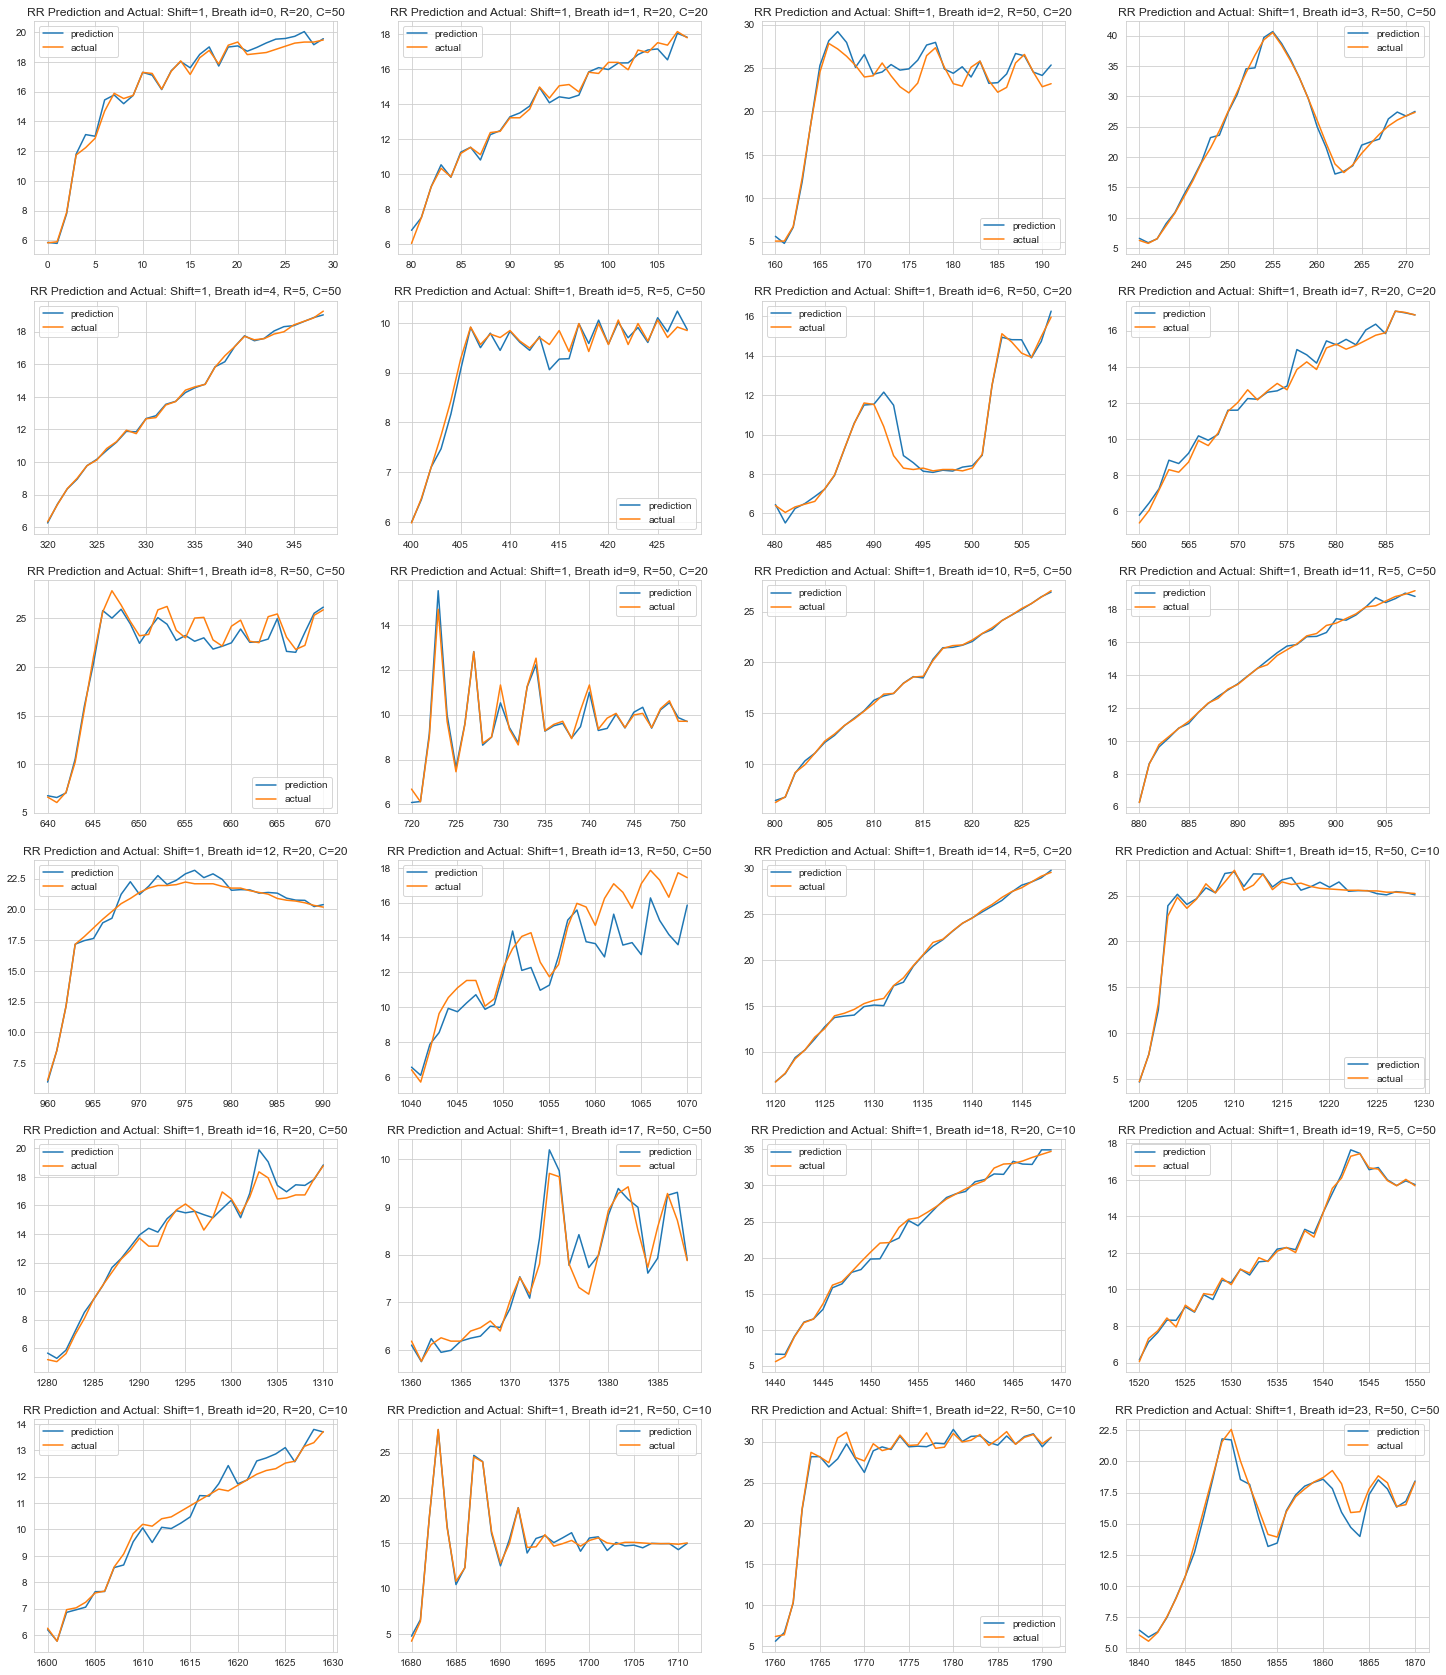

In [487]:
# make this a function
breath_idx = train_in.breath_id.unique()
fig, ax = plt.subplots(6, 4, figsize=(25,30))
ax = ax.flatten()
for i in range(24):
    b_id = get_breath(post_analysis,breath_idx[i])
    r = b_id.R.iloc[0]
    c = b_id.C.iloc[0]
    ax[i].plot(b_id.prediction,label='prediction')
    ax[i].plot(b_id.acutal,label='actual')
    ax[i].set_title(f'RR Prediction and Actual: Shift=1, Breath id={i}, R={r}, C={c}')
    ax[i].legend();
    
# plt.savefig('v6_shift=1_rf.png')
